In [ ]:
import os
import shutil
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import zipfile

In [ ]:
# Path direktori data
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Fungsi untuk membersihkan isi direktori
def clean_directory(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"Direktori lama dihapus: {path}")
    os.makedirs(path)
    print(f"Direktori baru dibuat: {path}")

# Bersihkan dan buat ulang direktori
for d in [train_dir, val_dir, test_dir]:
    clean_directory(d)

Direktori lama dihapus: /content/data/train
Direktori baru dibuat: /content/data/train
Direktori lama dihapus: /content/data/val
Direktori baru dibuat: /content/data/val
Direktori lama dihapus: /content/data/test
Direktori baru dibuat: /content/data/test


In [ ]:
# Ekstrak file ZIP
zip_path = '/content/data.zip'
extract_path = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File berhasil diekstrak ke:", extract_path)

File berhasil diekstrak ke: /content/data


In [ ]:
# Siapkan folder train dan val
train_dir = '/content/data/train'
val_dir = '/content/data/val'
test_dir = '/content/data/test'


os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report

In [ ]:
# Data generator dan augmentasi
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen_val_test = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 16

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

num_classes = train_generator.num_classes
input_shape = (28, 28, 1)

print(f"Jumlah kelas: {num_classes}")
print(f"Input shape: {input_shape}")

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
Jumlah kelas: 36
Input shape: (28, 28, 1)


In [ ]:
# Definisi Model CNN-LSTM
model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', padding='valid', input_shape=input_shape),
    layers.Conv2D(32, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),

    layers.Reshape((4, 4*64)),
    layers.LSTM(128, return_sequences=False),

    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,820 (979.77 KB)

 Trainable params: 250,820 (979.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Pelatihan Model
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

history = model.fit(
    train_generator,
    epochs=75,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.0451 - loss: 3.5457 - val_accuracy: 0.1713 - val_loss: 2.7984 - learning_rate: 0.0010
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.2145 - loss: 2.6705 - val_accuracy: 0.5556 - val_loss: 1.5982 - learning_rate: 0.0010
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.4762 - loss: 1.7479 - val_accuracy: 0.6389 - val_loss: 1.1679 - learning_rate: 0.0010
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6290 - loss: 1.1729 - val_accuracy: 0.8056 - val_loss: 0.6676 - learning_rate: 0.0010
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6916 - loss: 0.9840 - val_accuracy: 0.8009 - val_loss: 0.5848 - learning_rate: 0.0010
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7468 - loss: 0.6945 - val_accuracy: 0.8565 - val_loss: 0.4791 - learning_rate: 0.0010
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8015 - loss: 0.6176 

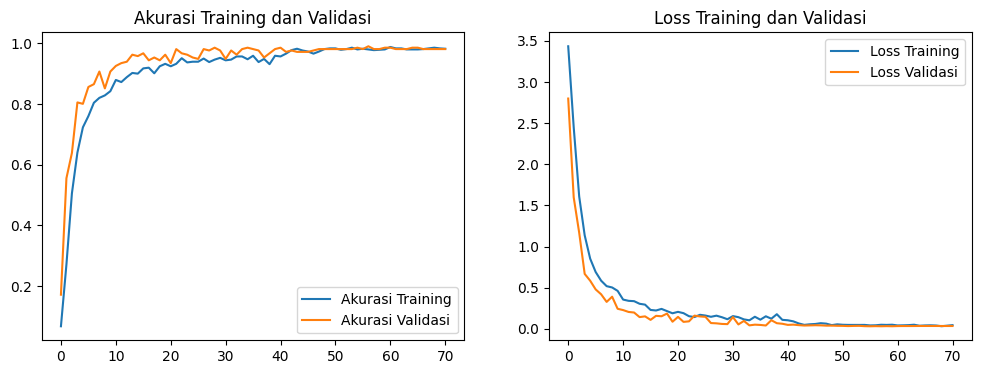

In [ ]:
# Plot Hasil Pelatihan
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Akurasi Training')
plt.plot(epochs_range, val_acc, label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Akurasi Training dan Validasi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Training')
plt.plot(epochs_range, val_loss, label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Loss Training dan Validasi')
plt.show()

In [ ]:
# Evaluasi Model pada Data Tes
print("\nEvaluasi pada data tes:")
loss_test, accuracy_test = model.evaluate(test_generator)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")


Evaluasi pada data tes:
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9681 - loss: 0.0549
Test Loss: 0.0311
Test Accuracy: 0.9815


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

Classification Report:
              precision    recall  f1-score   support

     class_0       0.67      0.67      0.67         6
     class_1       1.00      1.00      1.00         6
     class_2       1.00      1.00      1.00         6
     class_3       1.00      1.00      1.00         6
     class_4       1.00      1.00      1.00         6
     class_5       1.00      1.00      1.00         6
     class_6       1.00      1.00      1.00         6
     class_7       1.00      1.00      1.00         6
     class_8       1.00      1.00      1.00         6
     class_9       1.00      1.00      1.00         6
     class_A       1.00      1.00      1.00         6
     class_B       1.00      1.00      1.00         6
     class_C       1.00      1.00      1.00         6
     class_D       1.00      1.00      1.00         6
     class_E       1.00      1.00      1.00         6
     class_F       1.00      1.00      1.00         6
     class_G     

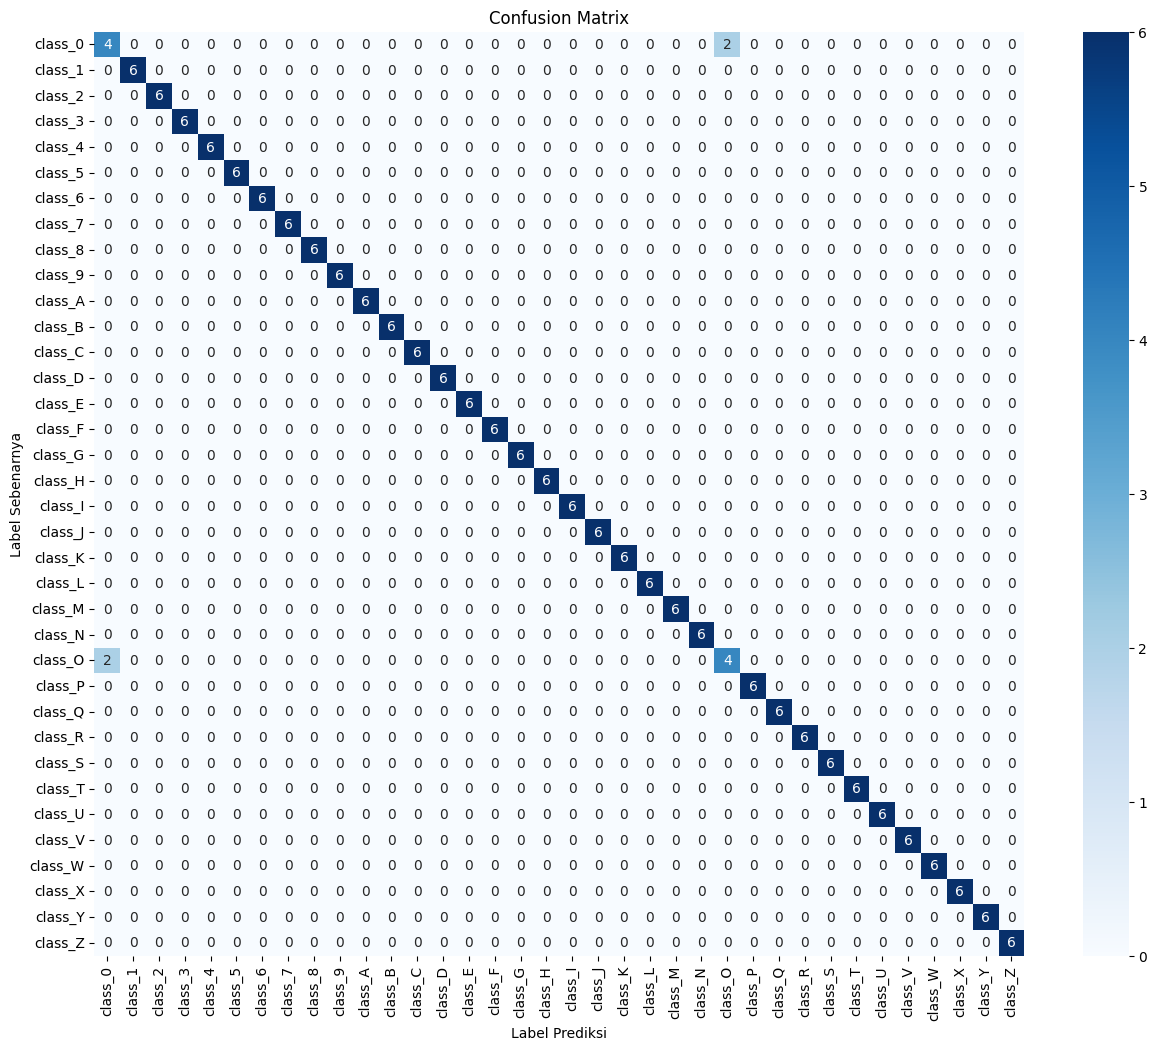

In [ ]:
# Classification Report dan Confusion Matrix
test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels, zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Label Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Simpan Model CNN-LSTM
model_save_path = '/content/model_karakter_cnnlstm.h5'
model.save(model_save_path)
print(f"Model CNN-LSTM berhasil disimpan sebagai '{model_save_path}'")

Model CNN-LSTM berhasil disimpan sebagai '/content/model_karakter_cnnlstm.h5'


In [ ]:
from tensorflow.keras.models import load_model

# Muat model CNN-LSTM
loaded_cnnlstm_model = load_model(model_save_path)

# Label kelas
class_labels_map = {v: k.replace('class_', '') for k, v in train_generator.class_indices.items()}
print(class_labels_map)

def preprocess_single_char_image(img_path, target_size=(28,28)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Gambar tidak ditemukan di {img_path}")
        return None
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized / 255.0
    # Reshape untuk model: (1, height, width, channels)
    img_reshaped = img_normalized.reshape(1, target_size[0], target_size[1], 1)
    return img_reshaped

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Karakter yang diprediksi: Z


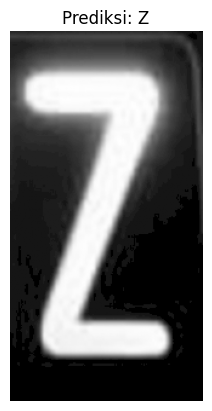

In [ ]:
# Prediksi Gambar Tunggal
test_char_image_path = '/content/Z.PNG'

if os.path.exists(test_char_image_path):
    input_char_image = preprocess_single_char_image(test_char_image_path)
    if input_char_image is not None:
        prediction_char = model.predict(input_char_image)
        predicted_char_index = np.argmax(prediction_char)


        idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
        predicted_character_label = idx_to_class[predicted_char_index].replace('class_', '')


        print(f'Karakter yang diprediksi: {predicted_character_label}')

        # Tampilkan gambar asli
        original_img_to_show = cv2.imread(test_char_image_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(original_img_to_show, cmap='gray')
        plt.title(f'Prediksi: {predicted_character_label}')
        plt.axis('off')
        plt.show()
else:
    print(f"File gambar uji tidak ditemukan: {test_char_image_path}")